In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic

import sys
sys.path.append('./functions')

from box_io import load_beeframe_meta_from_box
from comb_loading import get_organized_colony_names
from comb_loading import load_colony_comb    
from comb_loading import create_colonies_summary
from comb_loading import visualize_colony
from mask_processing import get_distance_to_class
from mask_processing import get_interior_mask, dilate_class

In [2]:
comb_class = 2
wood_class = 1

load_meta_from_file = True
if load_meta_from_file:
    meta_file = "/home/golden/Dropbox/bee-comb/img_to_text_df_TOEDIT.csv"
    # MLS file path:
    meta_file = "/Users/michaelsmith/Library/CloudStorage/Box-Box/3D_nest_2021/img_to_text_df_TOEDIT.csv"
    beeframe_meta = pd.read_csv(meta_file)

In [3]:
colony_names = get_organized_colony_names(beeframe_meta)

colony_type_SH = "SH"
colony_type_DD = "DD"
max_week = 6

masks_folder_root = "/home/golden/kenya_drones/comb-detection/nest_photos"
# MLS path: 
masks_folder_root = "/Users/michaelsmith/Library/CloudStorage/Box-Box/3D_nest_2021/nest_photos"

colonies = []

for colony_name in colony_names:
    
    masks_folder_name = "warped_masks" # MLS - Should this be something different? Changed to: "warped_masks"
    colony = load_colony_comb(beeframe_meta, colony_name, 
                              masks_folder_root, masks_folder_name,
                              combine_ab=True, mirror_b=True
                             )
    if colony is None:
        print(f"skipping colony {colony_name}")
        continue
    # Sometimes there is a thin layer of false wood on comb edge
    # try to clean this up
    for day_ind, day in enumerate(colony):
        for frame_ind, frame in enumerate(day):
            colony[day_ind, frame_ind] = dilate_class(frame, comb_class, 4)
    if len(colony) > max_week:
        colony = colony[:max_week]
    print(f"loaded colony {colony_name} ({len(colony)} weeks sorted.)")
    colonies.append({"colony": colony, "type": colony_name[:2], "name": colony_name})

No valid info for frame 1, CC1, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC1 (1 weeks sorted.)
No valid info for frame 1, CC2, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC2 (1 weeks sorted.)
No valid info for frame 1, CC5, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC5 (1 weeks sorted.)
No valid info for frame 1, CC6, 20210811.
returning None
Colony is missing frame info. Returning day until this point.
loaded colony CC6 (1 weeks sorted.)


KeyboardInterrupt: 

In [17]:
save = True
save_folder = "/home/golden/Dropbox/bee-comb/plots"
# MLS path: 
save_folder = "/Users/michaelsmith/Library/CloudStorage/Box-Box/3D_nest_2021/plots"

os.makedirs(save_folder, exist_ok=True)

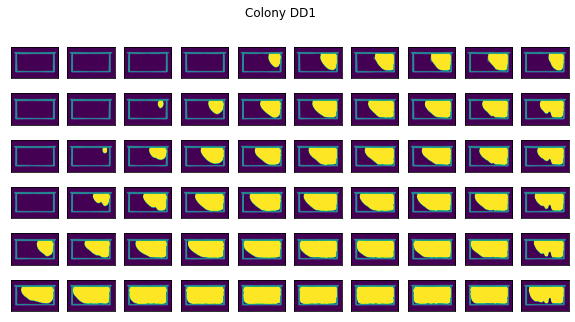

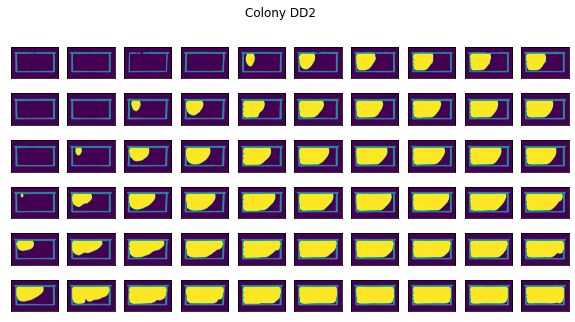

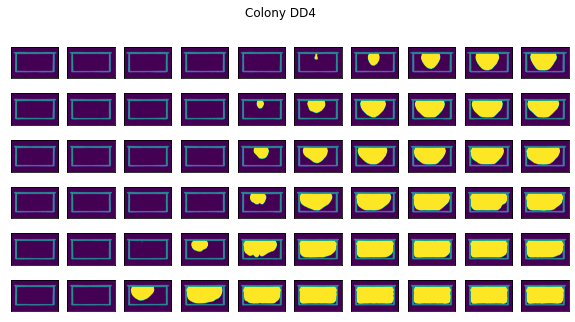

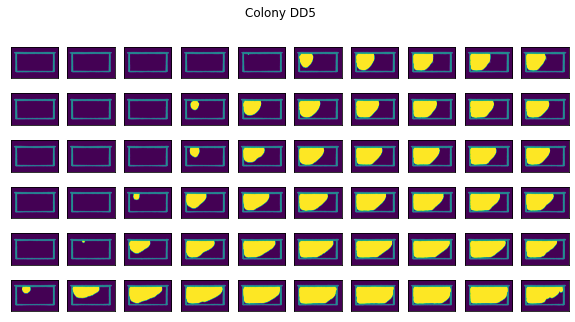

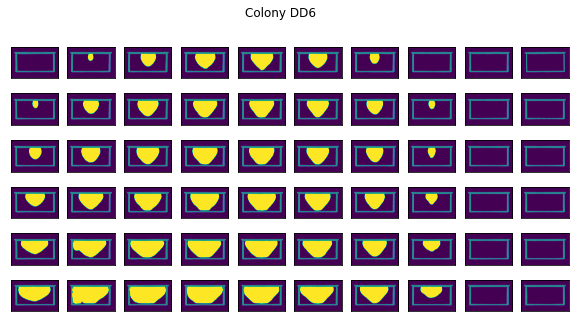

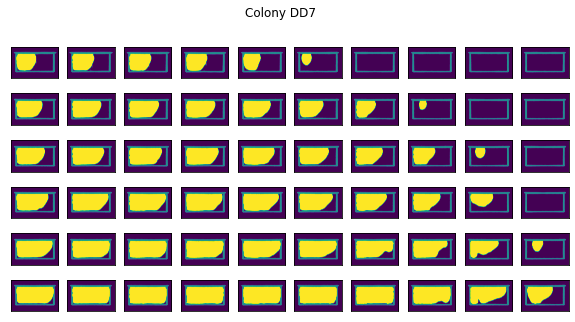

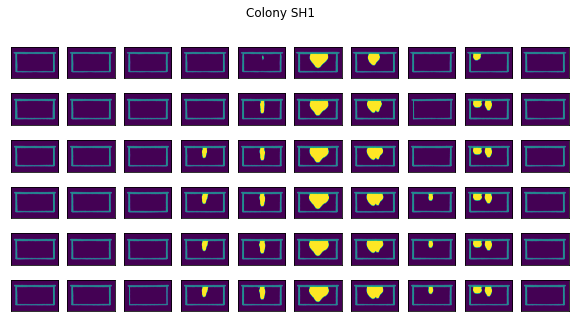

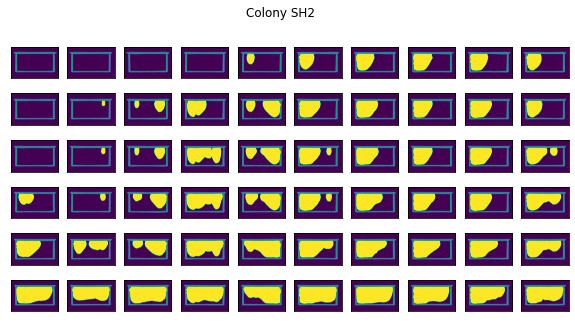

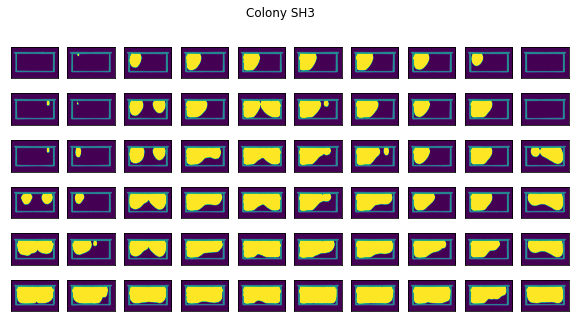

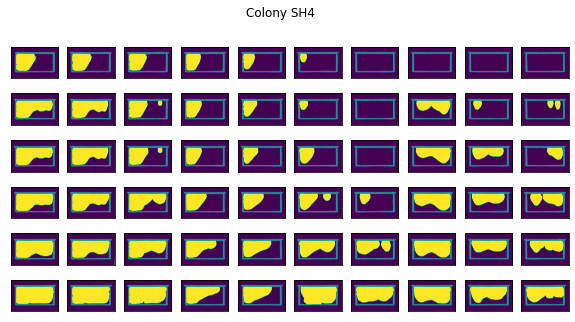

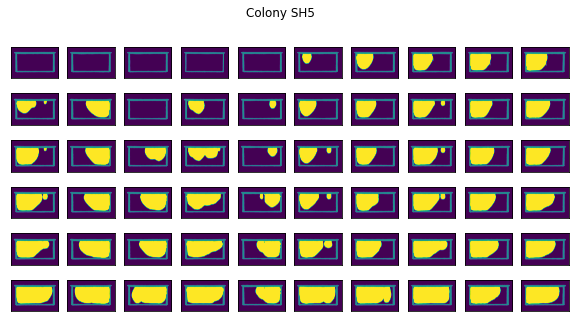

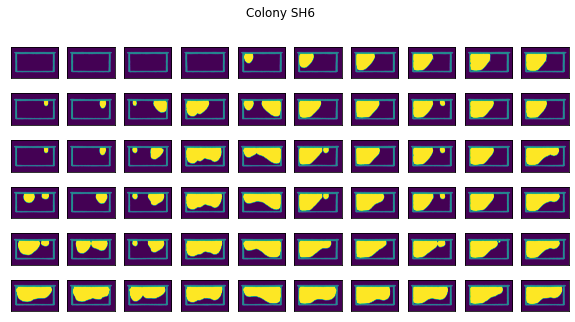

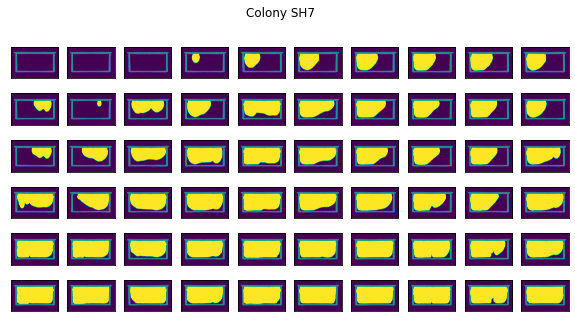

In [18]:

for colony_dict in colonies[:]:

    fig = visualize_colony(colony_dict['colony'], 
                          colony_name=colony_dict['name'],
                          figsize=(10,5)
                          )
    filename = f"whole_colony_{colony_dict['name']}.png"
    if save:
        fig.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

In [19]:
interior_mask = get_interior_mask(colonies[0]['colony'][0][0])
num_interior_pixels = np.sum(interior_mask)
frame_contents = create_colonies_summary(colonies, comb_class, wood_class,
                                         num_interior_pixels)

mean wood range: 0.2779931574698819, 0.2974984134175436
mean wood range: 0.28294642808986775, 0.2951387781298951


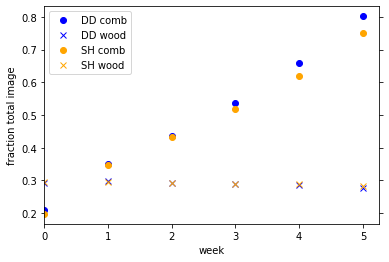

In [20]:
mean_comb = frame_contents.groupby(['type', 'week'])['comb_fraction'].mean()
mean_wood = frame_contents.groupby(['type', 'week'])['wood_fraction'].mean()
for exp_type in ["DD", "SH"]:
    if exp_type == "DD":
        color = 'b'
    elif exp_type == "SH":
        color = 'orange'
    
    plt.plot(mean_comb[exp_type], 'o', c=color, label=f"{exp_type} comb")
    plt.gca().set_xlim([0, None])
    plt.plot(mean_wood[exp_type], 'x', c=color, label=f"{exp_type} wood")
    plt.gca().yaxis.set_ticks_position('both')
    plt.legend()
    plt.xlabel("week")
    plt.ylabel("fraction total image")
    
    print(f"mean wood range: {mean_wood[exp_type].min()}, {mean_wood[exp_type].max()}")
    
    if save:
        filename = f"average_wood_and_comb_area_by_week_by_condition.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

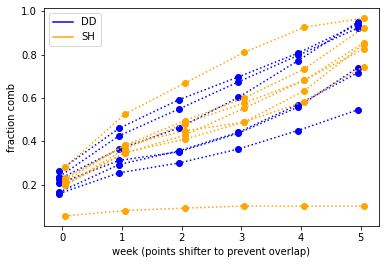

In [21]:
columns = ['type', 'colony', 'week']
plot_shift = .05
gb_mean = frame_contents.groupby(columns)['comb_fraction'].mean()
for exp_type in gb_mean.index.unique(level=0):
    exp_colonies = gb_mean[exp_type]
    if exp_type == "DD":
        color = 'b'
        ps = -1 * plot_shift
    elif exp_type == "SH":
        color = 'orange'
        ps =  plot_shift
    for colony_name in exp_colonies.index.unique(level=0):
        mean_comb_weeks = exp_colonies[colony_name]
        plt.plot(np.arange(len(mean_comb_weeks)) + ps,
                 mean_comb_weeks, 
                 "o", c=color
                )
        plt.plot(np.arange(len(mean_comb_weeks)) + ps,
                 mean_comb_weeks, 
                 ":", c=color
                )
plt.xlabel("week (points shifter to prevent overlap)")
plt.ylabel("fraction comb")
legend_elements = [Line2D([0], [0], color='b', label='DD'),
                   Line2D([0], [0], color='orange', label='SH'),
                   ]
plt.legend(handles=legend_elements)

if save:
        filename = f"average_wood_and_comb_area_by_colony_by_week_by_condition.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')

mean wood range: 0.2779931574698819, 0.2974984134175436
mean wood range: 0.2815177076984756, 0.296070579098102


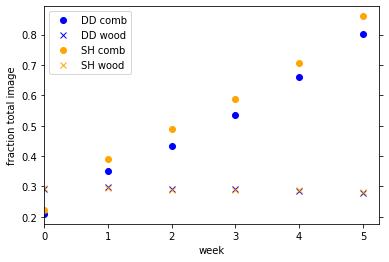

In [22]:
frame_contents_not_SH1 = frame_contents.loc[frame_contents['colony']!="SH1"]
mean_comb = frame_contents_not_SH1.groupby(['type', 'week'])['comb_fraction'].mean()
mean_wood = frame_contents_not_SH1.groupby(['type', 'week'])['wood_fraction'].mean()
for exp_type in ["DD", "SH"]:
    if exp_type == "DD":
        color = 'b'
    elif exp_type == "SH":
        color = 'orange'
    
    plt.plot(mean_comb[exp_type], 'o', c=color, label=f"{exp_type} comb")
    plt.gca().set_xlim([0, None])
    plt.plot(mean_wood[exp_type], 'x', c=color, label=f"{exp_type} wood")
    plt.gca().yaxis.set_ticks_position('both')
    plt.legend()
    plt.xlabel("week")
    plt.ylabel("fraction total image")
    
    print(f"mean wood range: {mean_wood[exp_type].min()}, {mean_wood[exp_type].max()}")
    
    if save:
        filename = f"average_wood_and_comb_area_by_week_by_condition_excluding_SH1.png"
        plt.savefig(os.path.join(save_folder, filename),
                   dpi=300, bbox_inches='tight')